In [159]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import ptitprince as pt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from Bio import AlignIO
import warnings
import mdtraj as md
from pylab import *
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import roc_curve, auc
from scipy.stats import bootstrap
import itertools
warnings.filterwarnings('ignore')

In [160]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [161]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}

In [162]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [163]:
def pearson_output(x,y):
    return sp.stats.pearsonr(x,y)[0]

In [164]:
def spearman_output(x,y):
    return sp.stats.spearmanr(x,y)[0]

In [165]:
def load_data_csv(data,wt_seq,sep=',',start_gap=0,column_score=1):
    df=pd.read_csv(data, sep=sep, comment='#',header=1)
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    
    scores_stop=np.empty((len(wt_seq),1),dtype=float)
    scores_stop[:]=np.nan
    
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][len(mutation_load[i])-1]!= '*' :
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
        
        elif mutation_load[i][len(mutation_load[i])-1]== '*':
            scores_stop[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap]= float(score_load[i])

    return scores, scores_stop

In [166]:
def load_prism(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=':
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

In [167]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [168]:
def print_chimera_x_attribute_file(attribute_check,attribute,file,model_id='#1',chain_id='/A',argument='cbyvalue'):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s%s\n%s\n%s\n' % ( 'attribute: ',argument,'match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True or attribute_check[i]==-99999:
            pass
        else:
            file.write("\t%s%s%s%d\t%f\n" % (str(model_id),str(chain_id),':',i+1,attribute[i]))
    file.close()

In [169]:
def heatmap_scores_reordered(ext_score,label_cm,WT_mask,lim_down,lim_up,color,x,WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,7],xtick_spacing=10):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf
    
    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:
                    
                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])
            
    fig, ax = plt.subplots(figsize=(figs[0],figs[1]))
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
 
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up,interpolation='nearest')
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    
    #ax.xaxis.set_ticks(np.arange(1, end, stepsize))

    plt.grid(axis='both',which='both',alpha=0.4)
    #plt.ylabel("mutation")
    plt.xlabel("Position")
    plt.ylim(-0.5,19.5)
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1
    
    print(score_nan[0,:])
    plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')
    

In [170]:
def heatmap_classification_WT(ext_score,WT_seq,x,region_spec='all',color_spec=[],ticks_label_start=1,ticks_spacing=10,fig_size=[40,10]):
# Plot the heatmap of the input color based classification matrix
# It's possible to plot only one of the region using the region number
# It's mandatory for the single region plot to assign a color using a list with two colors

    score=np.copy(ext_score)
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=5
    
    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]

    #plot of the entire classification heatmap with the current color scheme.
    if region_spec=='all':
        ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442","#56b4e9", "#009e74","#5A5A5A"]),interpolation='nearest')

    # this part manages the plot of specific region, the other one are set to 0 and the designed region is set to 1 (binary map) 
    else:
        for i in range(score.shape[0]):
            for j in range(score.shape[1]):
                if np.isnan(score[i,j]) == True:
                    pass
                else:
                    if score[i,j] == region_spec:
                        score[i,j]=1
                    else:
                        score[i,j]=0
        for i in range(len(WT_seq)):
            score[i,alphabetAA_L_D[WT_seq[i]]-1]=2
        ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(color_spec))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation")
    plt.xlabel("residue")

    plt.ylim(-0.5,19.5)
    
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    print(start,end)
    
    ax.xaxis.set_ticks(np.arange(start+0.5, end, ticks_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)

    xlabels= np.arange(ticks_label_start, ticks_label_start+(end-start), ticks_spacing,dtype=int)
    ax.set_xticklabels(xlabels)


In [171]:
def correlation_plot(x,y,x_label='score1',y_label='score2',nan_value=-99999,max=-99999):
    

    
    def func(x, a, b):
        return a * x + b
    
    rng = np.random.default_rng()
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))    
    
    bad = ~np.logical_or(np.isnan(x), np.isnan(y)) 
    
    x_t=np.compress(bad, x)
    y_t=np.compress(bad, y)

    xy= np.vstack([x_t,y_t])
    z = sp.stats.gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    
    ax.grid(alpha=0.3)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    
    
    x_s, y_s, z = x_t[idx], y_t[idx], z[idx]
    surf= ax.scatter(x_s, y_s, c=z, s=100,cmap='viridis')
        
    #stats

    
    print("spearman's r:", spearman_output(x_s,y_s))
    
    #correlation line

    
#     optimizedParameters, pcov = curve_fit(func, x_s, y_s);
    
#     ax.plot(x_s,func(x_s, *optimizedParameters),'r' ,label="fit" )
    
    ## bootstrap statistic
    
    res = bootstrap((x_s, y_s), spearman_output, vectorized=False, paired=True,
                random_state=rng)
    
    print("boostraping confidence interval:", res.confidence_interval)
    

In [172]:
#Custom color map
Wistia = mpl.cm.get_cmap('YlOrBr', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp = ListedColormap(newcolors)

In [173]:
#Custom color map
Wistia = mpl.cm.get_cmap('Blues', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp2 = ListedColormap(newcolors)

## Loading Datasets
### Load WT sequence

In [174]:
ASPA_WT_sequence="MTSCHIAEEHIQKVAIFGGTHGNELTGVFLVKHWLENGAEIQRTGLEVKPFITNPRAVKKCTRYIDCDLNRIFDLENLGKKMSEDLPYEVRRAQEINHLFGPKDSEDSYDIIFDLHNTTSNMGCTLILEDSRNNFLIQMFHYIKTSLAPLPCYVYLIEHPSLKYATTRSIAKYPVGIEVGPQPQGVLRADILDQMRKMIKHALDFIHHFNEGKEFPPCAIEVYKIIEKVDYPRDENGEIAAIIHPNLQDQDWKPLHPGDPMFLTLDGKTIPLGGDCTVYPVFVNEAAYYEKKEAFAKTTKLTLNAKSIRCCLH"
ASPA_WT_2o53_seq="--------EHIQKVAIFGGTHGNELTGVFLVKHWLENGAEIQRTGLEVKPFITNPRAVKKCTRYIDCDLNRIFDLENLGKKMSEDLPYEVRRAQEINHLFGPKDSEDSYDIIFDLHNTTSNMGCTLILEDSRNNFLIQMFHYIKTSLAPLPCYVYLIEHPSLKYATTRSIAKYPVGIEVGPQPQGVLRADILDQMRKMIKHALDFIHHFNEGKEFPPCAIEVYKIIEKVDYPRDENGEIAAIIHPNLQDQDWKPLHPGDPMFLTLDGKTIPLGGDCTVYPVFVNEAAYYEKKEAFAKTTKLTLNAKSIRC---"

In [175]:
len(ASPA_WT_sequence)

313

### Load MAVE data

In [249]:
ASPA_scores,ASPA_stop_scores=load_data_csv('../inputs_to_share/vamp_aspa.csv',ASPA_WT_sequence,sep=';',column_score=2)

In [177]:
ASPA_scores_med=np.nanmedian(ASPA_scores,axis=1)

In [178]:
df_synonimous=pd.read_csv('../Inputs/wt_syn_aspa.csv',sep=";")

ASPA_syn_scores=np.array([i for i in df_synonimous['vamp_score'] if np.isnan(i)==False])

In [179]:
ASPA_syn_scores_med=np.nanmedian(ASPA_syn_scores)

In [180]:
ASPA_syn_scores_min=np.nanmin(ASPA_syn_scores)

### Load computational data
- Example: Rosetta Scores ASPA

In [241]:
rosetta_ASPA_monomer=load_prism("../inputs_to_share/prism_rosetta_2o53_monomer_zinc.txt",ASPA_WT_2o53_seq,0)
rosetta_ASPA_monomer=remove_WT_score(rosetta_ASPA_monomer,ASPA_WT_sequence)

In [242]:
rosetta_ASPA_monomer_avg=np.nanmedian(rosetta_ASPA_monomer,axis=1)

In [243]:
normalized_rosetta_ASPA_monomer=normalize_cutoff(rosetta_ASPA_monomer,0,5)

In [244]:
normalized_rosetta_ASPA_monomer_avg=np.nanmedian(normalized_rosetta_ASPA_monomer,axis=1)

In [245]:
rosetta_ASPA_dimer=load_prism("../inputs_to_share/prism_rosetta_2o53_dimer_zn.txt",ASPA_WT_2o53_seq,0)
rosetta_ASPA_dimer=remove_WT_score(rosetta_ASPA_dimer,ASPA_WT_sequence)
rosetta_ASPA_dimer/=2

In [246]:
rosetta_ASPA_dimer_avg=np.nanmedian(rosetta_ASPA_dimer,axis=1)

In [247]:
normalized_rosetta_ASPA_dimer=normalize_cutoff(rosetta_ASPA_dimer,0,5)

In [248]:
normalized_rosetta_ASPA_dimer_avg=np.nanmedian(normalized_rosetta_ASPA_dimer,axis=1)

- GEMME score

In [252]:
#better correlation including more sequences in this case, probably due to low amunt of sequence at e-20 (500) the extra 200 from e-5 helped
GEMME_ASPA_scores=load_data("../inputs_to_share/prism_gemme_e5_scores.txt",ASPA_WT_sequence)
GEMME_ASPA_scores=remove_WT_score(GEMME_ASPA_scores,ASPA_WT_sequence)

In [253]:
GEMME_ASPA_scores_med=np.nanmedian(GEMME_ASPA_scores,axis=1)

- confidence score

In [250]:
df_confidence=pd.read_csv('../inputs_to_share/ASPA_bfactor_AF.txt',delim_whitespace=True)
ASPA_confidence_score=np.empty((len(ASPA_WT_sequence),1),dtype=float)
ASPA_confidence_score[:]=np.nan

In [251]:
for i,k in df_confidence.iterrows():
    ASPA_confidence_score[int(k[0])-1]=float(k[1])

## gnomad and clinvar

In [254]:
gnomad_ASPA_freq_db=pd.read_csv('../inputs_to_share/prism_gnomad_001_P45381-ENST00000263080-ENSG00000108381.mis.txt', delim_whitespace=True,comment='#')

In [255]:
gnomad_ASPA_freq_db_matrix=np.empty((len(ASPA_WT_sequence),20),dtype=float)
gnomad_ASPA_freq_db_matrix[:]=np.nan

mutation_load=gnomad_ASPA_freq_db['variant'].to_numpy()
score_load=gnomad_ASPA_freq_db['AF_tot'].to_numpy()
for i in range(1,len(mutation_load)):
    gnomad_ASPA_freq_db_matrix[int(mutation_load[i][1:-1])-1,int(alphabetAA_L_D[mutation_load[i][-1]])-1]=score_load[i]   

### New DB patho variants

In [256]:
db_variants_martin_new=pd.read_excel('../inputs_to_share/Updated variant pathogenicity dataset for matteo v2 no 1from 2from data.xlsx')

In [257]:
db_variants_martin_new

,Variant,Patogenicity,Catalytic_res
0,M1T,Pathogenic,no
1,V14G,Pathogenic,no
2,I16T,Pathogenic,no
3,G18R,Pathogenic,no
4,H21P,Pathogenic,yes
...,...,...,...
100,V281M,VUS,no
101,T302M,VUS,no
102,R309C,VUS,no
103,R309H,VUS,no


In [197]:
clinvar_ASPA_db_matrix=np.empty((len(ASPA_WT_sequence),20),dtype=float)
clinvar_ASPA_db_matrix[:]=np.nan

for i in db_variants_martin_new.query('Patogenicity == "Benign" ')['Variant']:
        clinvar_ASPA_db_matrix[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1]=0
for i in db_variants_martin_new.query('Patogenicity == "Pathogenic" ')['Variant']:
        clinvar_ASPA_db_matrix[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1]=1
for i in db_variants_martin_new.query('Patogenicity == "VUS" ')['Variant']:
        clinvar_ASPA_db_matrix[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1]=2    

In [198]:
clinvar_ASPA_catres_matrix=np.empty((len(ASPA_WT_sequence),20),dtype=float)
clinvar_ASPA_catres_matrix[:]=np.nan

for i in db_variants_martin_new.query('Catalytic_res == "no" ')['Variant']:
        clinvar_ASPA_catres_matrix[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1]=1  
for i in db_variants_martin_new.query('Catalytic_res == "yes" ')['Variant']:
        clinvar_ASPA_catres_matrix[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1]=0

In [199]:
mutation_disease=[]
extract_catres=[]
extract_disease=[]
extract_mave=[]
extract_gemme=[]
extract_ddg=[]
extract_gnomad=[]
extract_AFidr=[]
for i in range(clinvar_ASPA_db_matrix.shape[0]):
    for j in range(clinvar_ASPA_db_matrix.shape[1]):
        if np.isnan(clinvar_ASPA_db_matrix[i,j]):
            pass
        else:
            mutation_disease.append(ASPA_WT_sequence[i]+str(i+1)+alphabetAA_D_L[j+1])
            if  clinvar_ASPA_db_matrix[i,j]==0:
                extract_disease.append('benign')
            elif clinvar_ASPA_db_matrix[i,j] == 1:
                extract_disease.append('pathogenic')
            elif clinvar_ASPA_db_matrix[i,j] == 2:
                extract_disease.append('VUS')
                
            extract_catres.append(clinvar_ASPA_catres_matrix[i,j])
            
            if np.isnan(gnomad_ASPA_freq_db_matrix[i,j]):
                extract_gnomad.append(np.inf)
            else:
                extract_gnomad.append(gnomad_ASPA_freq_db_matrix[i,j])
            extract_mave.append(ASPA_scores[i,j])
            extract_gemme.append(GEMME_ASPA_scores[i,j])
            extract_ddg.append(rosetta_ASPA_monomer[i,j])
            extract_AFidr.append(ASPA_confidence_score[i])

In [200]:
df_disease= pd.DataFrame({'mutation': mutation_disease,'disease':extract_disease ,"catres_dist":extract_catres,'mave':extract_mave, 'gemme': extract_gemme, 'ddg_AF':extract_ddg,'freq_gnomad':extract_gnomad,'AF_confidence':extract_AFidr})


In [201]:
df_disease

,mutation,disease,catres_dist,mave,gemme,ddg_AF,freq_gnomad,AF_confidence
0,M1T,pathogenic,1.0,NaN,-1.006358,-0.063103,inf,[44.53]
1,C4R,VUS,1.0,1.054482,-0.450686,-0.728621,inf,[62.98]
2,V14G,pathogenic,1.0,0.011583,-3.395172,NaN,inf,[98.74]
3,I16T,pathogenic,1.0,0.069122,-3.662634,2.272529,0.000008,[98.91]
4,G18R,pathogenic,1.0,0.053267,-3.346580,12.053448,inf,[98.86]
...,...,...,...,...,...,...,...,...
100,T302M,VUS,1.0,0.886425,-0.382961,1.460920,0.000010,[98.68]
101,A305E,pathogenic,1.0,0.084117,-1.601234,NaN,0.000185,[97.28]
102,R309C,VUS,1.0,0.768237,-0.330780,NaN,0.000024,[93.05]
103,R309H,VUS,1.0,0.937715,-0.631203,NaN,0.000020,[93.05]


In [259]:
#df_disease.to_csv('../Outputs/ASPA_disease_variants_2022.csv',sep=',')

### degron exp

In [258]:
temp=pd.read_csv('../inputs_to_share/psi_degron7_june22.csv')
ASPA_degron_tiles=[]
count=11
for i,n in temp[temp['name'].str.startswith('ASPA')].iterrows():    
    ASPA_degron_tiles.append([count,float(n['mean_merge']),float(n['sd_merge'])])
    count +=12
ASPA_degron_tiles=np.array(ASPA_degron_tiles)

In [204]:
### to exp to chimera
ASPA_degron_residues=np.zeros(len(ASPA_WT_sequence),dtype=float)

for i in range((len(ASPA_WT_sequence)//12)):
    if i<35:
        ASPA_degron_residues[0+i*12:24+i*12]=ASPA_degron_tiles[i,1]
    else:
        ASPA_degron_residues[0+i*12:]=ASPA_degron_tiles[i,1]

In [205]:
#print_chimera_x_attribute_file(rosetta_ASPA_monomer_avg,ASPA_degron_residues,'../outputS/ASPA_chimera_degron_residues.defattr',model_id='#1',chain_id='/A',argument='degron')

#### single variant degron

In [206]:
ASPA_degron_single_tiles=pd.read_excel('../Inputs/single variant correlation data for Matteo.xlsx')

In [207]:
ASPA_degron_single_tiles

,Variant,Norm to WT #1,run 2# WT norm,# 3 WT norm,run 4,run 5,Mean,standdev
0,WT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,F29H,1.090909,1.191781,1.197368,1.348485,1.297619,1.225232,0.089854
2,N54K,0.515152,0.561644,0.513158,0.772727,0.702381,0.613012,0.105529
3,M82T,1.022727,0.945205,1.013158,1.136364,1.226190,1.068729,0.099831
4,D114Y,0.810606,0.753425,0.763158,0.939394,0.940476,0.841412,0.082739
5,C152W,0.204545,0.150685,0.123684,0.181818,0.088095,0.149766,0.041261
6,K163L,0.924242,0.931507,0.855263,1.196970,1.095238,1.000644,0.125892
7,E235K,1.000000,1.000000,0.907895,1.121212,1.190476,1.043917,0.099813
8,L263S,0.803030,0.821918,0.776316,0.939394,1.000000,0.868132,0.086338
9,E285A,1.075758,1.013699,1.000000,1.242424,1.273810,1.121138,0.115149


In [208]:
temp=[]
temp_err=[]
for i in ASPA_degron_single_tiles['Variant']:
    if i !='WT':
        temp.append(ASPA_scores[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1])
        #print(i, ASPA_scores[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1])
    else:
        temp.append(1.0)

In [209]:
ASPA_degron_single_tiles['vamp']=temp

In [210]:
ASPA_degron_single_tiles

,Variant,Norm to WT #1,run 2# WT norm,# 3 WT norm,run 4,run 5,Mean,standdev,vamp
0,WT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
1,F29H,1.090909,1.191781,1.197368,1.348485,1.297619,1.225232,0.089854,1.257487
2,N54K,0.515152,0.561644,0.513158,0.772727,0.702381,0.613012,0.105529,-0.004387
3,M82T,1.022727,0.945205,1.013158,1.136364,1.226190,1.068729,0.099831,0.993317
4,D114Y,0.810606,0.753425,0.763158,0.939394,0.940476,0.841412,0.082739,0.303283
5,C152W,0.204545,0.150685,0.123684,0.181818,0.088095,0.149766,0.041261,0.065717
6,K163L,0.924242,0.931507,0.855263,1.196970,1.095238,1.000644,0.125892,0.528699
7,E235K,1.000000,1.000000,0.907895,1.121212,1.190476,1.043917,0.099813,0.822480
8,L263S,0.803030,0.821918,0.776316,0.939394,1.000000,0.868132,0.086338,0.185619
9,E285A,1.075758,1.013699,1.000000,1.242424,1.273810,1.121138,0.115149,0.971988


### degron pred QC

In [211]:
temp=pd.read_csv('../Inputs/QCDpred.txt',delim_whitespace=True)
print(temp)
ASPA_pred_degron_tiles=np.zeros(len(ASPA_WT_sequence),dtype=float)
for i,n in enumerate(temp['resi']):
    ASPA_pred_degron_tiles[int(n)-1]=temp['deg_prob'][i]

     name           sequence  deg_prob aa  resi
0    ASPA  MTSCHIAEEHIQKVAIF   0.72450  E     9
1    ASPA  TSCHIAEEHIQKVAIFG   0.56933  H    10
2    ASPA  SCHIAEEHIQKVAIFGG   0.49713  I    11
3    ASPA  CHIAEEHIQKVAIFGGT   0.49987  Q    12
4    ASPA  HIAEEHIQKVAIFGGTH   0.40159  K    13
..    ...                ...       ... ..   ...
292  ASPA  EAFAKTTKLTLNAKSIR   0.45738  L   301
293  ASPA  AFAKTTKLTLNAKSIRC   0.70215  T   302
294  ASPA  FAKTTKLTLNAKSIRCC   0.75516  L   303
295  ASPA  AKTTKLTLNAKSIRCCL   0.75617  N   304
296  ASPA  KTTKLTLNAKSIRCCLH   0.73150  A   305

[297 rows x 5 columns]


### Extra DF

In [212]:
df_ASPA_med=pd.DataFrame({'position': [i for i in range(1,len(ASPA_WT_sequence)+1)],'vampseq_median': ASPA_scores_med.flatten(), 'gemme_de':GEMME_ASPA_scores_med.flatten(),'normalized_rosetta_ddg_zinc': normalized_rosetta_ASPA_monomer_avg.flatten(),'norm_diff_ddg': normalized_rosetta_ASPA_dimer_avg-normalized_rosetta_ASPA_monomer_avg, 'AF_confidence':ASPA_confidence_score.flatten() })


In [213]:
# for colouring maps only

ASPA_scores_adj_colour=np.copy(ASPA_scores)

for (x,y),n in ndenumerate(ASPA_scores_adj_colour):
    if n > 1:
        ASPA_scores_adj_colour[x,y]+=n*0.25
        
        
ASPA_scores_adj_colour_med=np.nanmedian(ASPA_scores_adj_colour,axis=1)

### Experimental heatmaps

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


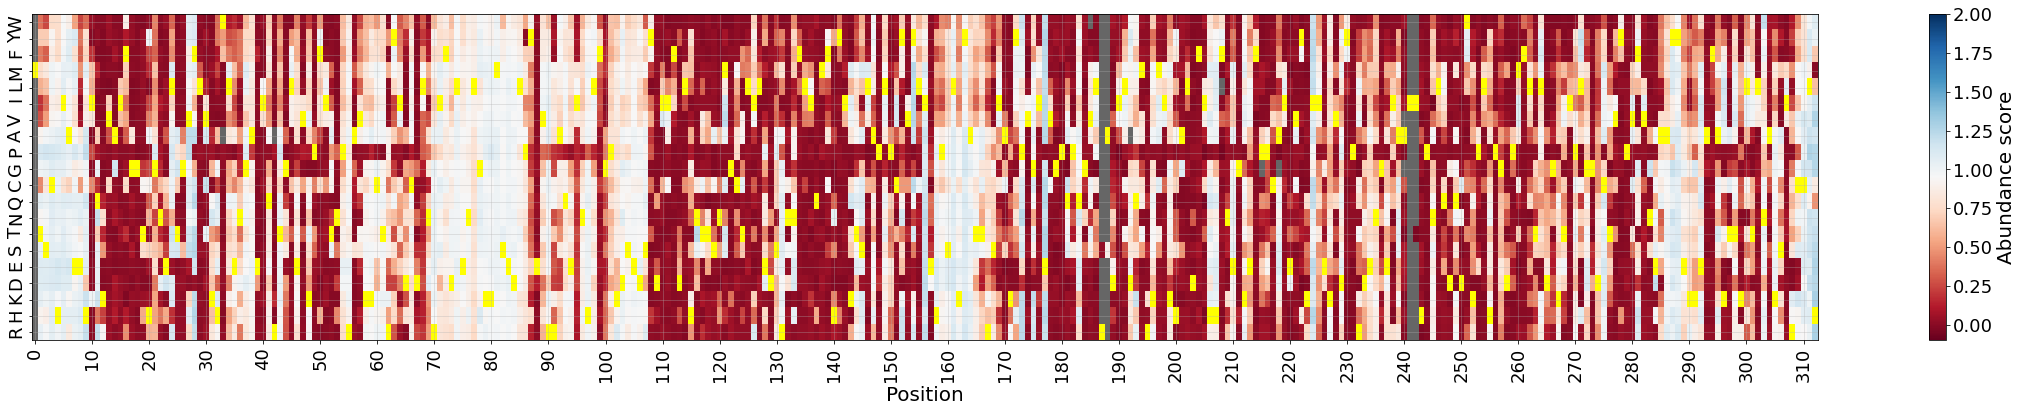

In [214]:
heatmap_scores_reordered(ASPA_scores,'Abundance score',ASPA_WT_sequence,2,0,'RdBu',[0,len(ASPA_WT_sequence)-1],figs=[40,6])
#plt.savefig('../Figures/ASPA_heatmap_MAVE_all_reordered.pdf',dpi=300, facecolor='w')

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf  1.
  1.  1.]


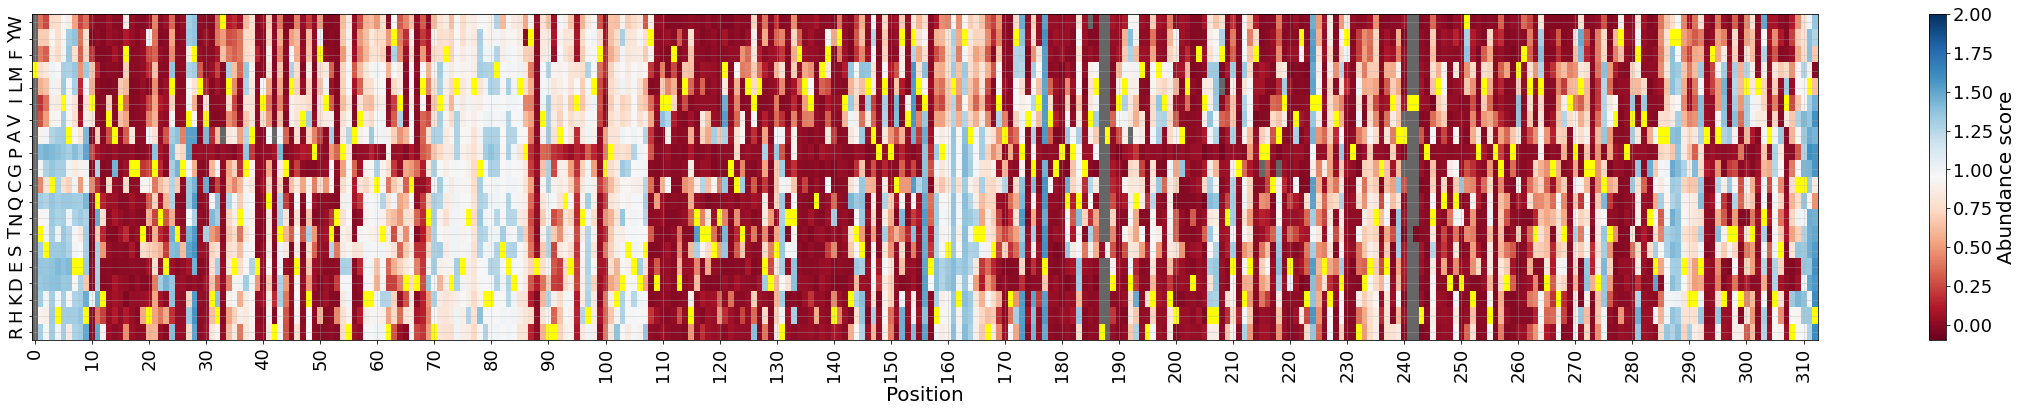

In [215]:
heatmap_scores_reordered(ASPA_scores_adj_colour,'Abundance score',ASPA_WT_sequence,2,0,'RdBu',[0,len(ASPA_WT_sequence)-1],figs=[40,6])
#plt.savefig('../Figures/ASPA_heatmap_MAVE_all_reordered.pdf',dpi=300, facecolor='w')

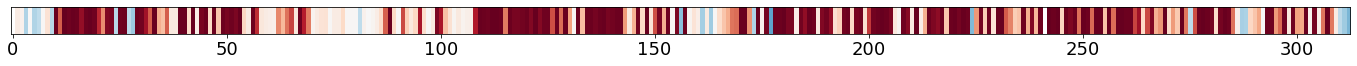

In [216]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(ASPA_scores_adj_colour_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_WT_sequence)+.5-1)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
#plt.tight_layout()
#plt.savefig('../Figures/ASPA_heamap_MAVE_med.pdf',dpi=300, facecolor='w')

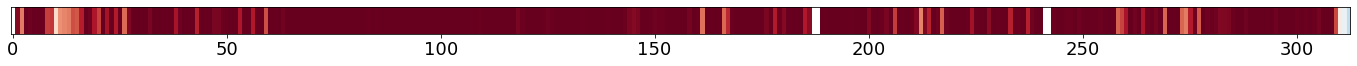

In [217]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(ASPA_stop_scores.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_WT_sequence)+.5-1)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
#plt.tight_layout()
#plt.savefig('../Figures/ASPA_heamap_MAVE_stop_2.pdf',dpi=300, facecolor='w')

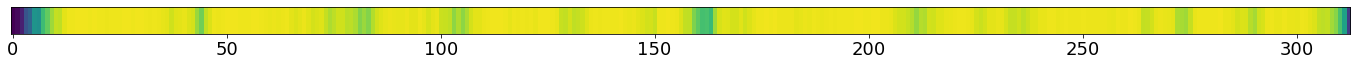

In [218]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(ASPA_confidence_score.reshape(1,-1),aspect= 'auto',cmap='viridis',vmin=50,vmax=100,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(ASPA_WT_sequence)+.5-1)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
#plt.tight_layout()
#plt.savefig('../Figures/ASPA_heamap_pLDDT.pdf',dpi=300, facecolor='w')

### Computational protocols heatmaps
- GEMME scores

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


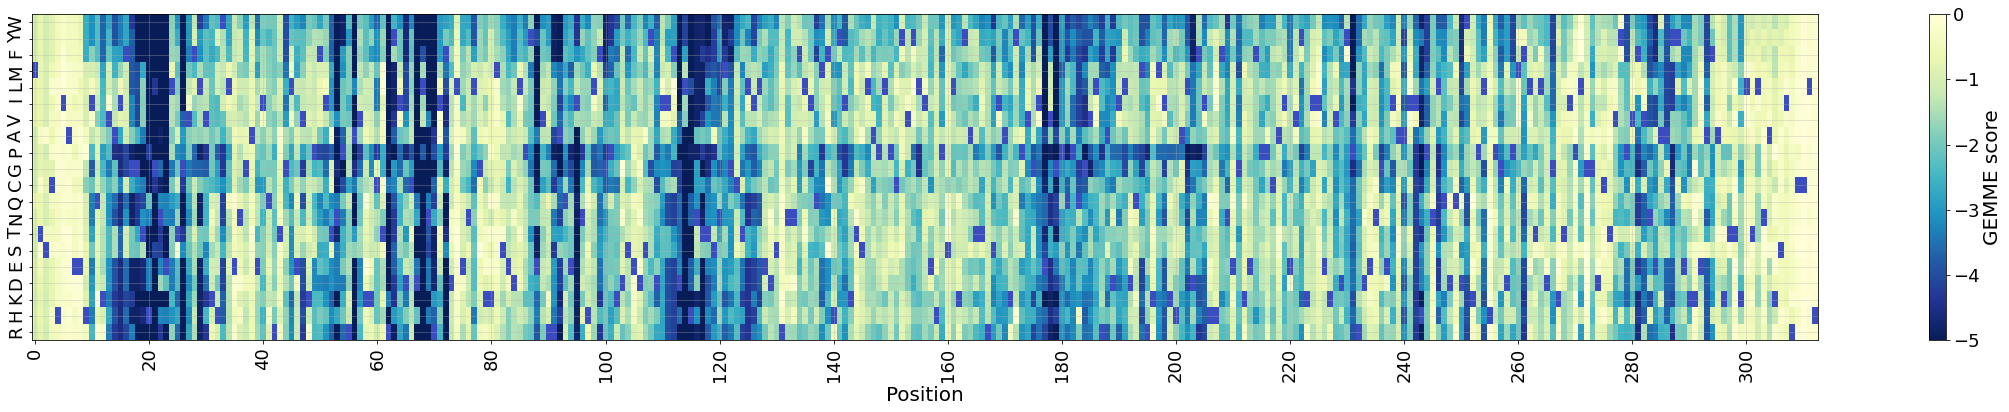

In [220]:
heatmap_scores_reordered(GEMME_ASPA_scores,'GEMME score',ASPA_WT_sequence,-5,0,'YlGnBu_r',[0,len(ASPA_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
#plt.savefig('../Figures/ASPA_heatmap_GEMME.pdf',dpi=300, facecolor='w')

In [223]:
print_chimera_x_attribute_file(rosetta_ASPA_monomer_avg,GEMME_ASPA_scores_med,'../outputS/ASPA_chimera_gemme_scores.txt',model_id='#1',argument='gemme')

- Rosetta ddg

[inf inf inf inf  1. inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


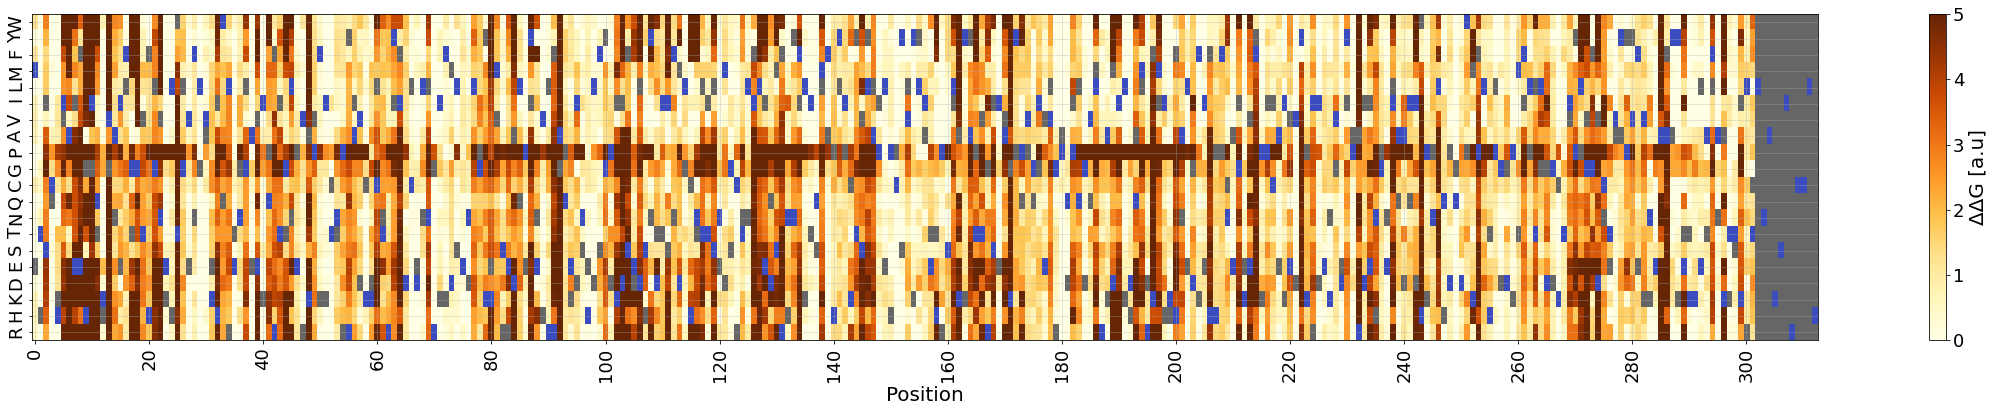

In [224]:
heatmap_scores_reordered(rosetta_ASPA_monomer,'\u0394\u0394G [a.u]',ASPA_WT_sequence,0,5,'YlOrBr',[0,len(ASPA_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
#plt.savefig('../Figures/ASPA_heatmap_ddg_monomer.pdf',dpi=300, facecolor='w')

[inf inf inf inf  1. inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


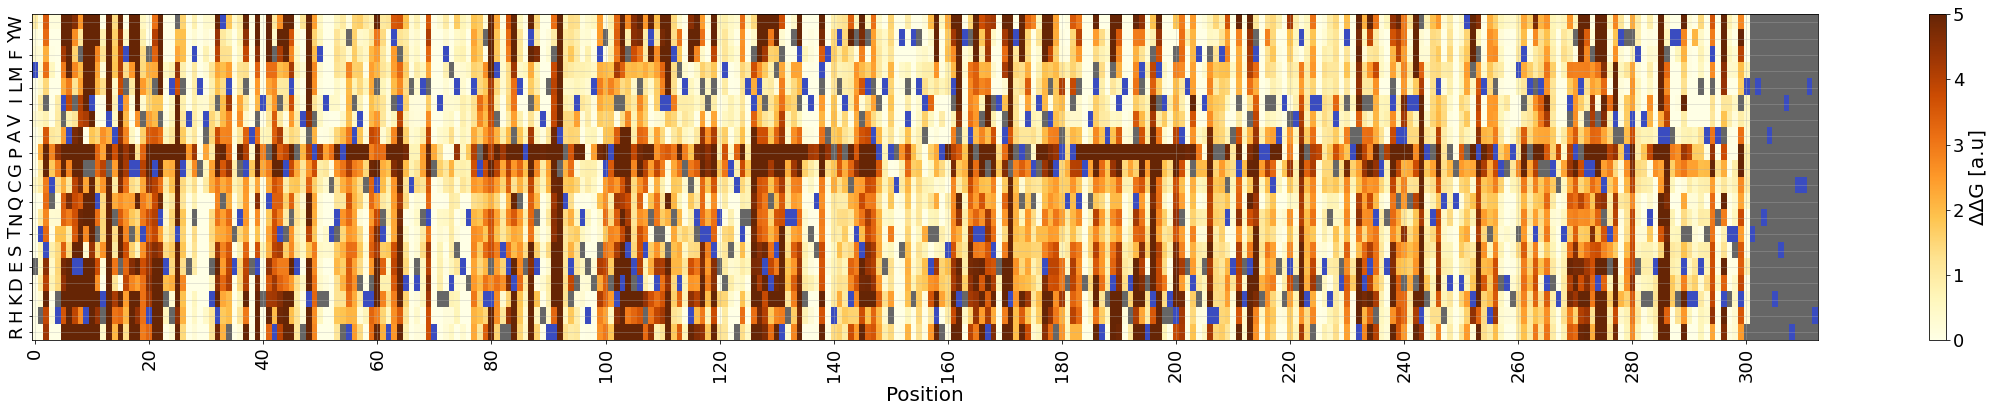

In [225]:
heatmap_scores_reordered(rosetta_ASPA_dimer,'\u0394\u0394G [a.u]',ASPA_WT_sequence,0,5,'YlOrBr',[0,len(ASPA_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
#plt.savefig('../Figures/ASPA_heatmap_ddg_dimer.pdf',dpi=300, facecolor='w')

[inf inf inf inf  1. inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


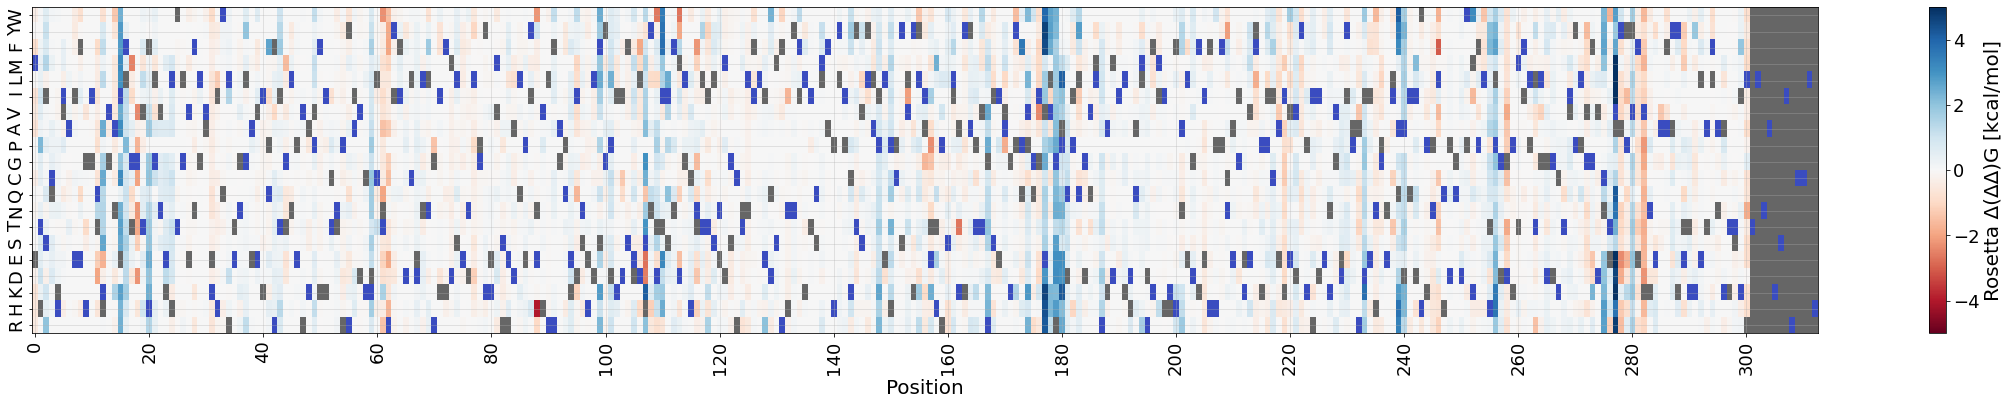

In [226]:
heatmap_scores_reordered(normalized_rosetta_ASPA_dimer-normalized_rosetta_ASPA_monomer,'Rosetta \u0394(\u0394\u0394)G [kcal/mol]',ASPA_WT_sequence,-5,5,'RdBu',[0,len(ASPA_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
#plt.savefig('../Figures/ASPA_heatmap_rosetta_reordered_diff.pdf',dpi=300, facecolor='w')

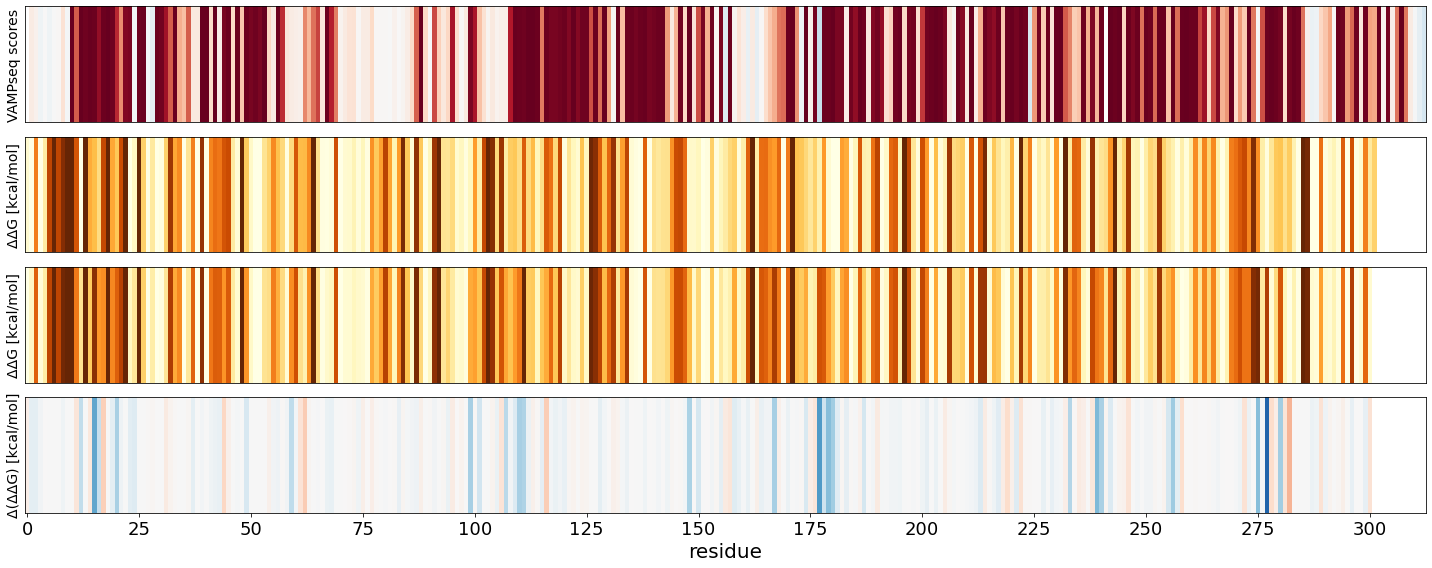

In [227]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax0),(ax1),(ax2),(ax3)) = plt.subplots(4,1,figsize=(20,8))

ax0.imshow(ASPA_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax0.set_yticks([])
ax0.set_ylabel('VAMPseq scores',fontsize=14)
ax0.set_xticks([])

ax1.imshow(normalized_rosetta_ASPA_monomer_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('\u0394\u0394G [kcal/mol]',fontsize=14)
ax1.set_xticks([])

ax2.imshow(normalized_rosetta_ASPA_dimer_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax2.set_yticks([])
ax2.set_ylabel('\u0394\u0394G [kcal/mol]',fontsize=14)
ax2.set_xticks([])


ax3.imshow(normalized_rosetta_ASPA_dimer_avg-normalized_rosetta_ASPA_monomer_avg.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=-5,vmax=+5,interpolation='nearest')
ax3.set_yticks([])
ax3.set_ylabel('\u0394(\u0394\u0394G) [kcal/mol]',fontsize=14)
ax3.set_xticks([])

ax3.set_xlabel('residue')
ax3.xaxis.set_ticks(np.arange(0, len(ASPA_WT_sequence), 25))

#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
plt.tight_layout()
plt.savefig('../Figures/ASPA_heatmap_rosetta_diff_res.pdf',dpi=300, facecolor='w')

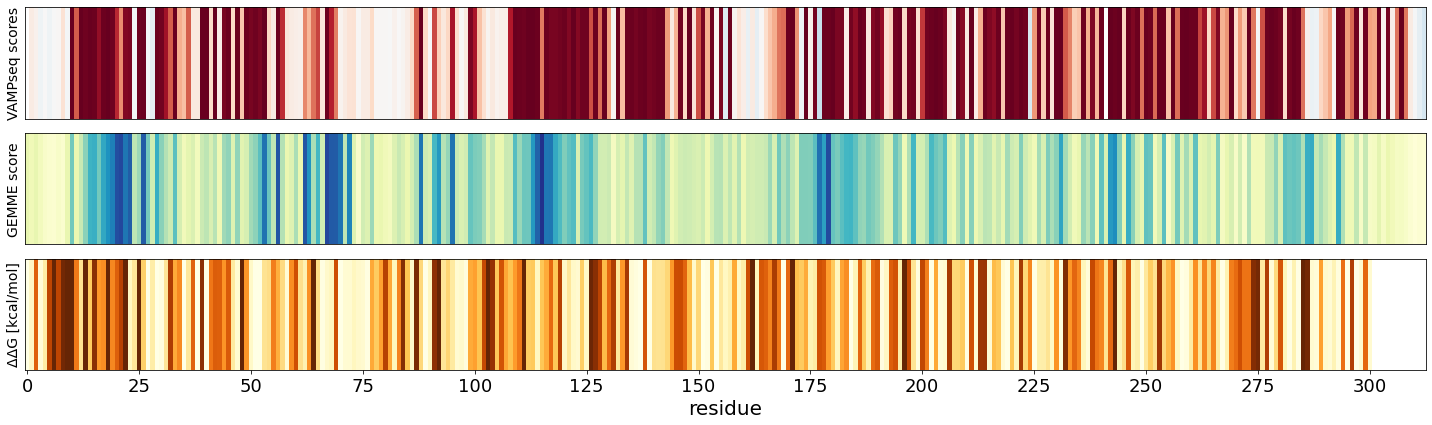

In [228]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax0),(ax1),(ax2)) = plt.subplots(3,1,figsize=(20,6))

ax0.imshow(ASPA_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax0.set_yticks([])
ax0.set_ylabel('VAMPseq scores',fontsize=14)
ax0.set_xticks([])

ax1.imshow(GEMME_ASPA_scores_med.reshape(1,-1),aspect= 'auto',cmap='YlGnBu_r',vmin=-7,vmax=0,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('GEMME score',fontsize=14)
ax1.set_xticks([])

ax2.imshow(normalized_rosetta_ASPA_dimer_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax2.set_yticks([])
ax2.set_ylabel('\u0394\u0394G [kcal/mol]',fontsize=14)
ax2.set_xticks([])

ax2.set_xlabel('residue')
ax2.xaxis.set_ticks(np.arange(0, len(ASPA_WT_sequence), 25))

#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/ASPA_comp_mode_comparison.pdf')
plt.tight_layout()
#plt.savefig('../Figures/ASPA_heatmap_comparisons.pdf',dpi=300, facecolor='w')

In [89]:
print_chimera_x_attribute_file(rosetta_ASPA_monomer_avg,normalized_rosetta_ASPA_dimer_avg-normalized_rosetta_ASPA_monomer_avg,'../outputS/ASPA_chimera_diff_dimer_scores.txt',model_id='#1',argument='diff_dimer')

### hist vamp-seq scores

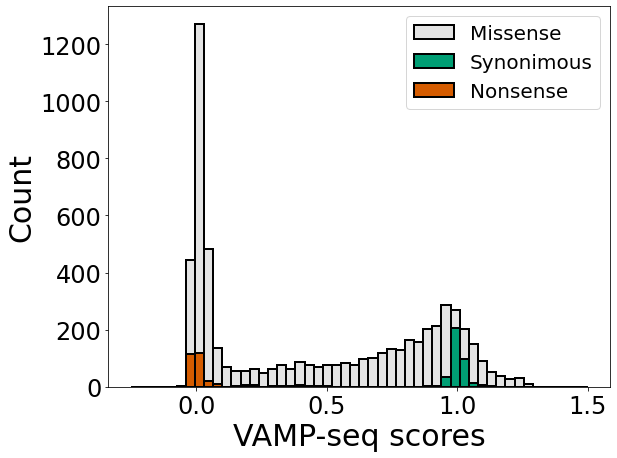

In [230]:
fig, ax = plt.subplots(figsize=(9,7))

ax.hist(ASPA_scores.flatten(),bins=50, range=(-0.25,1.5),facecolor='#e3e3e3',edgecolor='k',lw=2,label='Missense')
ax.hist(ASPA_syn_scores.flatten(),bins=50,range=(-0.25,1.5),facecolor='#009E74',edgecolor='k',lw=2,label='Synonimous')
ax.hist(ASPA_stop_scores.flatten(),bins=50,range=(-0.25,1.5),facecolor='#d55c00',edgecolor='k',lw=2,label='Nonsense')

ax.tick_params(axis='both',labelsize=24)
ax.legend(fontsize=20)
ax.set_xlabel('VAMP-seq scores',fontsize=30)
ax.set_ylabel('Count',fontsize=30)

#plt.savefig('../figures/hist_ASPA_score_syn_ter.pdf',tight_layout=True)

## Correlations with experiments:


spearman's r: 0.4803146241590303
boostraping confidence interval: ConfidenceInterval(low=0.4594316980929483, high=0.5007491471258632)


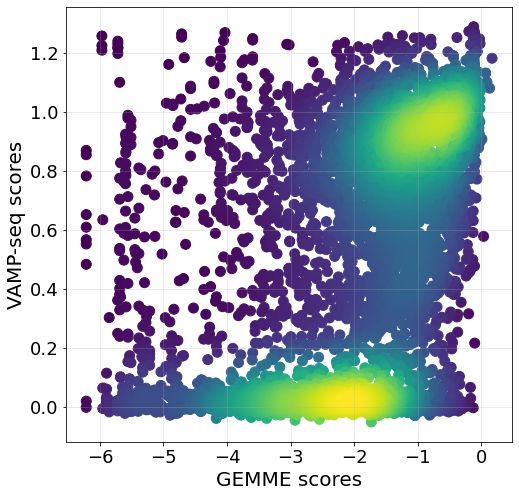

In [231]:
correlation_plot(GEMME_ASPA_scores.flatten(),ASPA_scores.flatten(),'GEMME scores', 'VAMP-seq scores')

#plt.savefig('../Figures/ASPAG_correlation_GEMME_full_VAMPseq.pdf',dpi=300, facecolor='w')

spearman's r: 0.494768736087064
boostraping confidence interval: ConfidenceInterval(low=0.4018988206995829, high=0.5774600712532455)


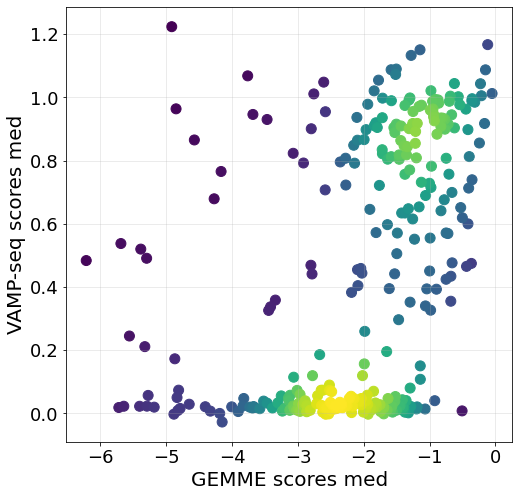

In [232]:
correlation_plot(GEMME_ASPA_scores_med.flatten(),ASPA_scores_med.flatten(),'GEMME scores med', 'VAMP-seq scores med')

#plt.savefig('../Figures/ASPAG_correlation_GEMME_full_VAMPseq_med.pdf',dpi=300, facecolor='w')

spearman's r: 0.004925208573226679
boostraping confidence interval: ConfidenceInterval(low=-0.022043592425292604, high=0.03086475293720954)


(5.5, -0.5)

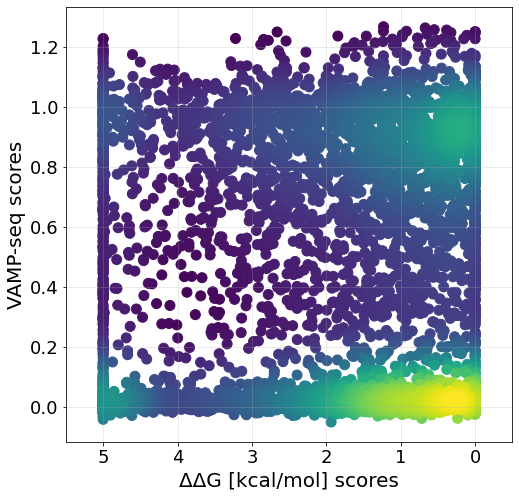

In [234]:
correlation_plot(normalized_rosetta_ASPA_monomer.flatten(),ASPA_scores.flatten(),'\u0394\u0394G [kcal/mol] scores', 'VAMP-seq scores')
plt.xlim(5.5,-0.5)
#plt.savefig('../Figures/ASPA_correlation_rosetta_full_VAMPseq.pdf',dpi=300, facecolor='w')

spearman's r: -0.0070724658094615854
boostraping confidence interval: ConfidenceInterval(low=-0.034420813476258416, high=0.02010595240650716)


(5.5, -0.5)

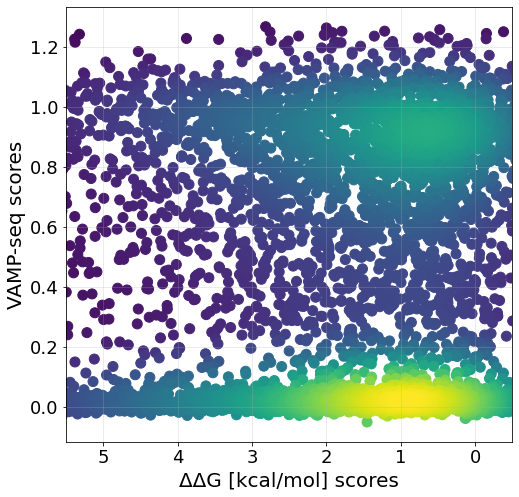

In [238]:
correlation_plot(normalized_rosetta_ASPA_dimer.flatten(),ASPA_scores.flatten(),'\u0394\u0394G [kcal/mol] scores', 'VAMP-seq scores')
plt.xlim(5.5,-0.5)
#plt.savefig('../Figures/ASPA_correlation_rosetta_full_VAMPseq_dimer.pdf',dpi=300, facecolor='w')

spearman's r: -0.008342370798448968
boostraping confidence interval: ConfidenceInterval(low=-0.12000123185051403, high=0.10590723630641875)


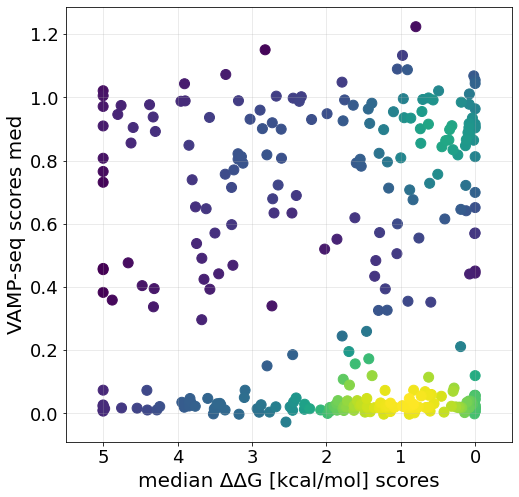

In [236]:
correlation_plot(normalized_rosetta_ASPA_monomer_avg.flatten(),ASPA_scores_med.flatten(),'median \u0394\u0394G [kcal/mol] scores', 'VAMP-seq scores med')
plt.xlim(5.5,-0.5)
#plt.savefig('../Figures/ASPA_correlation_rosetta_full_VAMPseq_med_monomer.pdf',dpi=300, facecolor='w')

spearman's r: -0.017063295938480647
boostraping confidence interval: ConfidenceInterval(low=-0.13051706363343965, high=0.09661126775408659)


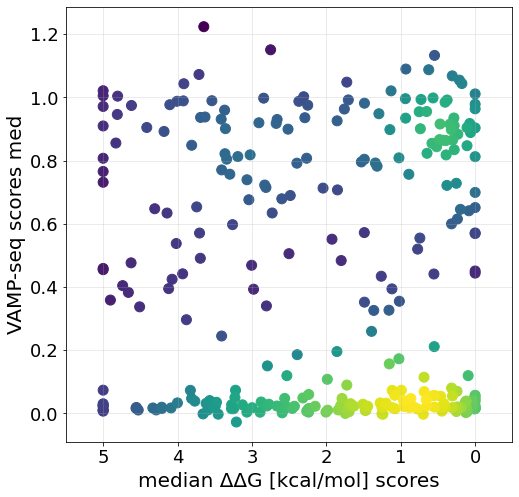

In [237]:
correlation_plot(normalized_rosetta_ASPA_dimer_avg.flatten(),ASPA_scores_med.flatten(),'median \u0394\u0394G [kcal/mol] scores', 'VAMP-seq scores med')
plt.xlim(5.5,-0.5)
#plt.savefig('../Figures/ASPA_correlation_rosetta_full_VAMPseq_med_dimer.pdf',dpi=300, facecolor='w')

In [102]:
## export all data as csv
mutant_list=[]
for i,n in enumerate(ASPA_WT_sequence):
    for j in range(20):
        mutant_list.append(n+str(i+1)+alphabetAA_D_L[j+1])

df_export=pd.DataFrame({'variant':mutant_list,'vamp-seq_scores': ASPA_scores.flatten(), 'gemme_de': GEMME_ASPA_scores.flatten(), 'norm rosetta_ddg_monomer_zinc': normalized_rosetta_ASPA_monomer.flatten(), 'norm rosetta_ddg_dimer_zinc': normalized_rosetta_ASPA_dimer.flatten(),'norm rosetta_ddg_diff_dimer-monomer':(normalized_rosetta_ASPA_dimer-normalized_rosetta_ASPA_monomer).flatten()})

In [103]:
#df_export.to_csv('../Outputs/ASPA_recap_variant_level.csv',sep=',')

## degron

### exp

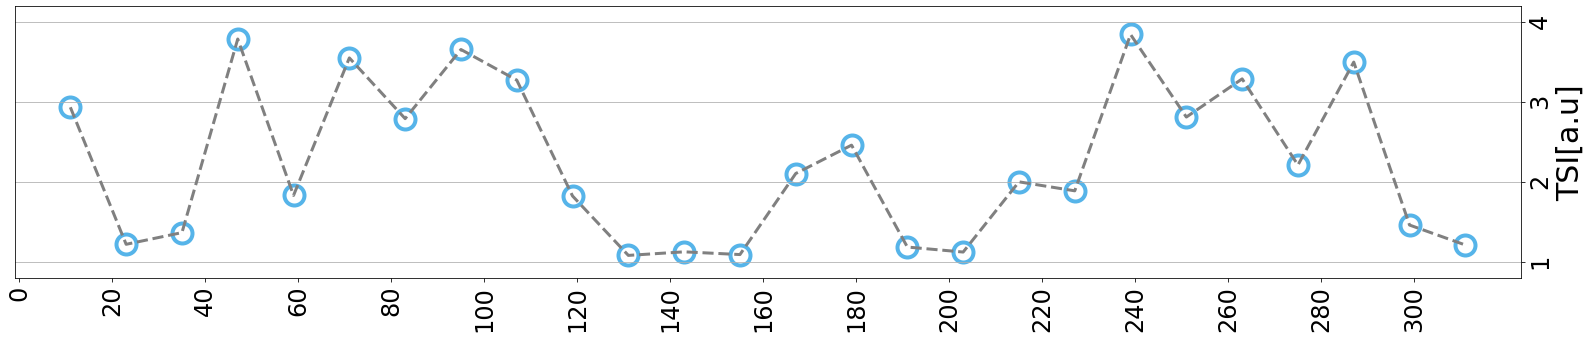

In [104]:
fig,ax =plt.subplots(1,1,figsize=(27,5))
ax.plot(ASPA_degron_tiles[:,0].flatten(),ASPA_degron_tiles[:,1].flatten(),ls='--',color='grey',lw=3)
idx= np.isfinite(ASPA_degron_tiles[:,1].flatten())
ax.scatter(ASPA_degron_tiles[:,0].flatten()[idx],ASPA_degron_tiles[:,1].flatten()[idx],marker='o',c='white',lw=2,s=400,facecolor='white',edgecolor='#56b4e9', linewidth=4)
ax.set_ylabel('TSI[a.u]',fontsize=30)
ax.set_xticks(np.arange(5, len(ASPA_WT_sequence), 12))
ax.set_ylim(0.8,4.2)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.set_xticks(np.arange(0, len(ASPA_WT_sequence),20))
ax.tick_params(axis='x',rotation=90)
ax.set_xticklabels(np.arange(0, len(ASPA_WT_sequence), 20),fontsize=24)
ax.set_xlim(-1,len(ASPA_WT_sequence)+10)

ax.set_yticks(np.arange(1, 4.5, 1))
ax.tick_params(axis='y',rotation=90)
ax.set_yticklabels(np.arange(1, 5, 1),fontsize=24)
ax.grid(axis='y',which='major')

plt.savefig('../Figures/ASPA_degron_exp_unique.pdf')

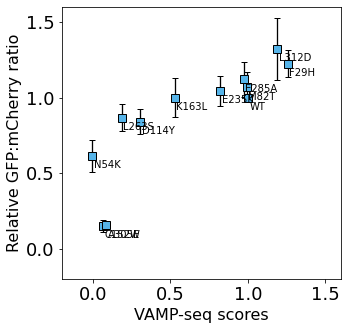

In [105]:
fig, ax = plt.subplots(figsize=(5,5))

ax.errorbar(ASPA_degron_single_tiles['vamp'],ASPA_degron_single_tiles['Mean'],yerr=ASPA_degron_single_tiles['standdev'],fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

label_single=ASPA_degron_single_tiles['Variant'].to_list()
for i, label in enumerate(label_single):
    ax.annotate(label, (ASPA_degron_single_tiles['vamp'][i]+0.01,ASPA_degron_single_tiles['Mean'][i]-0.08))

    
    
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# p0 = [max(ASPA_degron_single_tiles['Mean'].to_numpy().flatten()), np.median(ASPA_degron_single_tiles['vamp'].to_numpy().flatten()),0,min(ASPA_degron_single_tiles['Mean'].to_numpy().flatten())] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, ASPA_degron_single_tiles['vamp'].to_numpy().flatten(), ASPA_degron_single_tiles['Mean'].to_numpy().flatten(),p0, method='dogbox')
    
    
    
ax.set_xlim(-0.2,1.6)
ax.set_ylim(-0.2,1.6)

ax.set_xlabel('VAMP-seq scores',fontsize=16)
ax.set_ylabel('Relative GFP:mCherry ratio',fontsize=16)

#plt.savefig('../Figures/ASPA_tile_single_replicas.pdf')

### pred

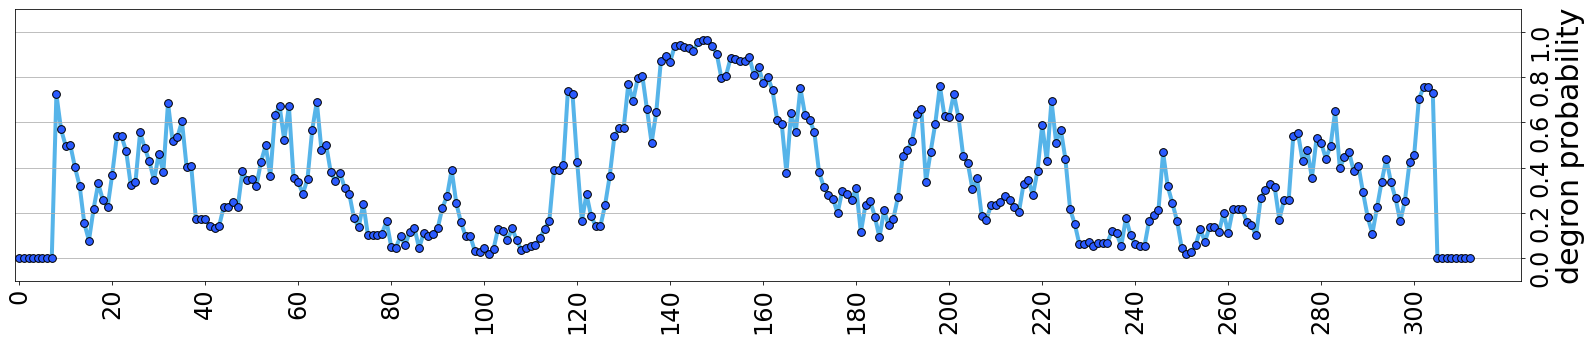

In [106]:
fig,ax =plt.subplots(1,1,figsize=(27,5))
ax.plot(np.arange(0,len(ASPA_WT_sequence),1),ASPA_pred_degron_tiles.flatten(),ls='-',color='#56B4E9',lw=4,zorder=1)
ax.scatter(np.arange(0,len(ASPA_WT_sequence),1),ASPA_pred_degron_tiles.flatten(),marker='o',lw=1,s=60,facecolor='#2B5BFF',edgecolor='k',zorder=10)
ax.set_ylabel('degron probability',fontsize=30)
ax.set_xticks(np.arange(5, len(ASPA_WT_sequence), 12))

ax.set_xlim(-1,313+10)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.set_xticks(np.arange(0, len(ASPA_WT_sequence),20))
ax.tick_params(axis='x',rotation=90)
ax.set_xticklabels(np.arange(0, len(ASPA_WT_sequence), 20),fontsize=24)

#ax.set_yticks(np.arange(0,1,0.2))
ax.tick_params(axis='y',rotation=90)
ax.set_yticklabels([-0.2,0.,.2,.4,.6,.8,1.],fontsize=24)
ax.set_ylim(-0.1,1.1)
ax.grid(axis='y',which='major')

#plt.savefig('../Figures/ASPA_degron_pred_unique.pdf')

## clinical analysis

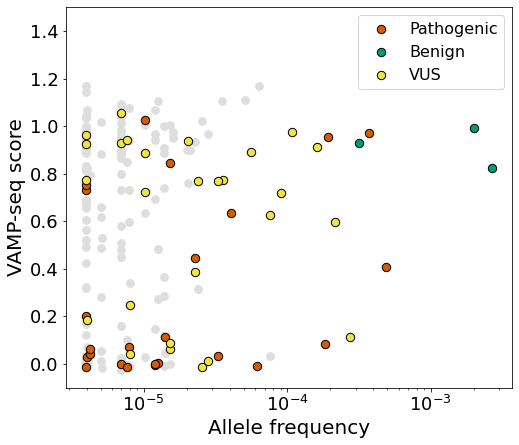

In [108]:
fig,ax=plt.subplots(1,1,figsize=(8,7))

ax.scatter(gnomad_ASPA_freq_db_matrix,ASPA_scores,c='#DEDEDE',s=60)

idx = np.isfinite(df_disease[df_disease['disease']=='pathogenic']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease[df_disease['disease']=='pathogenic']['mave'].to_numpy() )
ax.scatter(df_disease['freq_gnomad'][df_disease['disease']=='pathogenic'].to_numpy()[idx],df_disease['mave'][df_disease['disease']=='pathogenic'].to_numpy()[idx],c='#d55c00',s=70,edgecolors='k',label='Pathogenic')

idx = np.isfinite(df_disease[df_disease['disease']=='benign']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease[df_disease['disease']=='benign']['mave'].to_numpy() )
ax.scatter(df_disease[df_disease['disease']=='benign']['freq_gnomad'].to_numpy()[idx],df_disease[df_disease['disease']=='benign']['mave'].to_numpy()[idx],c='#009e74',s=70,edgecolors='k',label='Benign')

idx = np.isfinite(df_disease[df_disease['disease']=='VUS']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease[df_disease['disease']=='VUS']['mave'].to_numpy() )
ax.scatter(df_disease[df_disease['disease']=='VUS']['freq_gnomad'].to_numpy()[idx],df_disease[df_disease['disease']=='VUS']['mave'].to_numpy()[idx],c='#f0e442',s=70,edgecolors='k',label='VUS')

ax.set_xscale('log')
ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.5)
ax.legend(fontsize=16)
#plt.savefig('../figures/ASPA_gnomad_valid_frequency_variants.pdf')

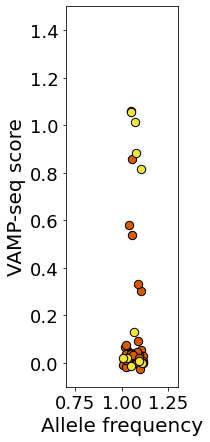

In [109]:
fig,ax=plt.subplots(1,1,figsize=(2,7))
temp=df_disease
temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='pathogenic':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
            
ax.scatter([1+random()/8 for i in range(0,len(temp_array))],temp_array,c='#d55c00',s=70,edgecolors='k')

temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='benign':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])

ax.scatter([1+random()/8 for i in range(0,len(temp_array))],temp_array,c='#009e74',s=70,edgecolor='k')
            
temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='VUS':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
            

ax.scatter([1+random()/8 for i in range(0,len(temp_array))],temp_array,c='#f0e442',s=70,edgecolor='k')


ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.5)
ax.set_xlim(0.7,1.3)
#plt.savefig('../figures/ASPA_gnomad_null_frequency_variants.pdf')

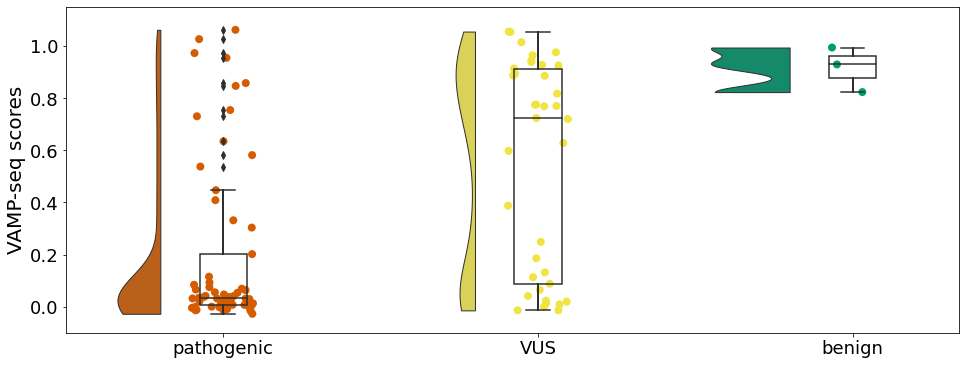

In [110]:
#same thing with a single command: now x **must** be the categorical value
dx = "disease"; dy = "mave"; ort = "v"; pal = "Set2"; sigma = .3
f, ax = plt.subplots(figsize=(16., 6))

ax1=pt.RainCloud(x = dx, y = dy, data = df_disease, palette = ['#d55c00','#f0e442','#009e74'],
      bw = sigma,width_viol = .5, ax = ax, orient = ort,point_size=8, point_color='black')
ax1.set_ylabel('VAMP-seq scores')
ax1.set_xlabel('')
#ax1.plot([-1,3],[PARKIN_syn_scores_med-PARKIN_syn_scores_stdev,PARKIN_syn_scores_med-PARKIN_syn_scores_stdev],c='gray',ls='--',zorder=-1,label='thresholds')
ax.set_ylim(-0.1,1.15)
#ax1.legend()

#plt.savefig('../figures/ASPA_pathogenic_benign_raincloud.pdf',tight_layout=True)

In [113]:
color_dict_cat={0:'#bdffff',1:'#B2BEB5'}

In [114]:
#### these cells are needed to replace points in the above raincloud, since it's not possible to use different color directly (done in Affinity)

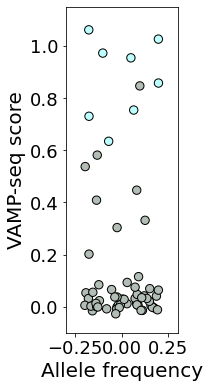

In [115]:
fig,ax=plt.subplots(1,1,figsize=(2,6))
temp=df_disease
temp_array=[]
temp_color=[]
for i in range(len(temp['mave'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='pathogenic':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
for i in range(len(temp['catres_dist'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='pathogenic':    
        temp_color.append(color_dict_cat[temp.iloc[i,temp.columns.get_loc('catres_dist')]])
                            
ax.scatter([0+((-1)**randint(1,3))*random()/5 for i in range(0,len(temp_array))],temp_array,c=temp_color,s=70,edgecolors='k')


ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.15)
ax.set_xlim(-0.3,0.3)
#plt.savefig('../figures/ASPA_pathogenic_pointplot_catalytic.pdf')

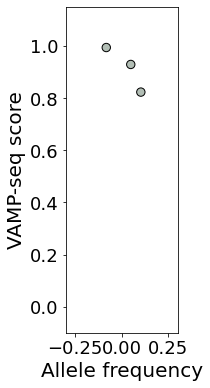

In [116]:
fig,ax=plt.subplots(1,1,figsize=(2,6))
temp=df_disease
temp_array=[]
temp_color=[]
for i in range(len(temp['mave'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='benign':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
for i in range(len(temp['catres_dist'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='benign':    
        temp_color.append(color_dict_cat[temp.iloc[i,temp.columns.get_loc('catres_dist')]])
                            
ax.scatter([0+((-1)**randint(1,3))*random()/5 for i in range(0,len(temp_array))],temp_array,c=temp_color,s=70,edgecolors='k')


ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.15)
ax.set_xlim(-0.3,0.3)
#plt.savefig('../figures/ASPA_benign_pointplot_catalytic.pdf')

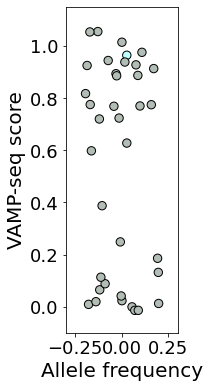

In [117]:
fig,ax=plt.subplots(1,1,figsize=(2,6))
temp=df_disease
temp_array=[]
temp_color=[]
for i in range(len(temp['mave'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='VUS':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
for i in range(len(temp['catres_dist'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='VUS':    
        temp_color.append(color_dict_cat[temp.iloc[i,temp.columns.get_loc('catres_dist')]])
                            
ax.scatter([0+((-1)**randint(1,3))*random()/5 for i in range(0,len(temp_array))],temp_array,c=temp_color,s=70,edgecolors='k')


ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.15)
ax.set_xlim(-0.3,0.3)
#plt.savefig('../figures/ASPA_vus_pointplot_catalytic.pdf')

### coevo vs vamp_seq with clinvar


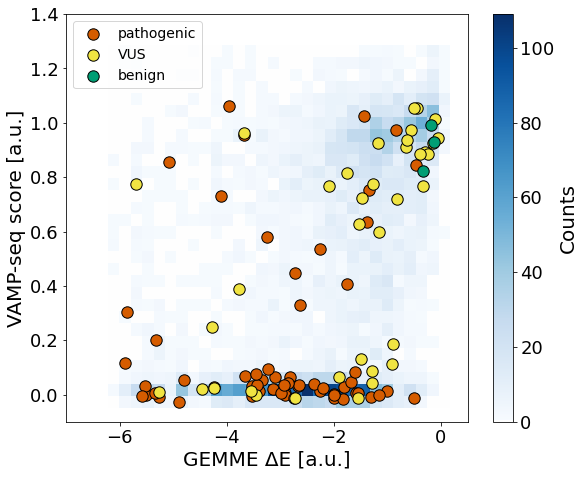

In [132]:
fig,ax=plt.subplots(1,1,figsize=(9,7.5))

y=[]; x=[]

y_size=[1.4,-0.1]
x_size=[-7,0.5]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(GEMME_ASPA_scores.shape[0]):
    for j in range(GEMME_ASPA_scores.shape[1]):
        if np.isnan(GEMME_ASPA_scores[i,j]) or np.isnan(ASPA_scores[i,j]):
            pass
        else:
            x.append(float(GEMME_ASPA_scores[i,j]))
            y.append(float(ASPA_scores[i,j]))

# Common variant assays
y=np.array(y)
x=np.array(x)

#Plot the 2d histogram
ax.set_ylabel("VAMP-seq score [a.u.]")
ax.set_xlabel("GEMME \u0394E [a.u.]")
mappable = ax.hist2d(x,y,bins=[30,30],cmap =newcmp2)# norm=mpl.colors.LogNorm()
cbar = fig.colorbar(mappable[3],label="Counts")

#plt.legend(loc='upper left',fontsize=12)
ax.set_xlim(x_size[0],x_size[1])
ax.set_ylim(y_size[1],y_size[0])

ax.scatter(df_disease[df_disease['disease']=='pathogenic']['gemme'].to_numpy(),df_disease[df_disease['disease']=='pathogenic']['mave'].to_numpy(),c='#d55c00',s=130,edgecolors='k',label='pathogenic')
ax.scatter(df_disease[df_disease['disease']=='VUS']['gemme'].to_numpy(),df_disease[df_disease['disease']=='VUS']['mave'].to_numpy(),c='#f0e442',s=130,edgecolors='k',label='VUS')
ax.scatter(df_disease[df_disease['disease']=='benign']['gemme'].to_numpy(),df_disease[df_disease['disease']=='benign']['mave'].to_numpy(),c='#009e74',s=130,edgecolors='k',label='benign')



#ax.scatter(df_disease_select[df_disease['mutation']=='G120D']['gemme'].to_numpy(),df_disease_select[df_disease['mutation']=='G120D']['ddg_soluble'].to_numpy(),c='#d55c00',s=130,edgecolors='k',label='G120D/L185P')
#ax.scatter(df_disease_select[df_disease['mutation']=='L185P']['gemme'].to_numpy(),df_disease_select[df_disease['mutation']=='L185P']['ddg_soluble'].to_numpy(),c='#d55c00',s=130,edgecolors='k')
ax.legend(loc='upper left')
#plt.savefig('../Figures/ASPA_2d_vamp_gemme_clinva.pdf')

In [140]:
count_wt=0
count_sbi=0
count_tl=0
count_outside=0
temp_gemme=df_disease[df_disease['disease']=='pathogenic']['gemme'].to_numpy()
for i,n in enumerate(df_disease[df_disease['disease']=='pathogenic']['mave'].to_numpy()):
        if n>0.5:
            if temp_gemme[i]>-3:
                count_wt+=1
            else:
                count_sbi+=1
        else:
            if temp_gemme[i]>-3:
                count_outside+=1
            else:
                count_tl+=1
                
        
print(count_wt,count_sbi,count_tl,count_outside)
print(count_wt/63,count_sbi/63,count_tl/63,count_outside/63)

6 5 23 29
0.09523809523809523 0.07936507936507936 0.36507936507936506 0.4603174603174603


### Hierchical clustering ASPA

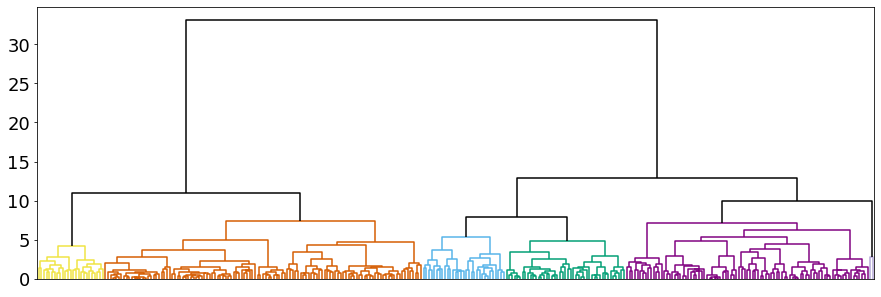

In [119]:
residues_distances=[]
for r in range(0,len(ASPA_WT_sequence)):
    temp=[]
    if np.isnan(ASPA_scores_med[r]):
        for j in range(20):
            if alphabetAA_D_L[j+1]==ASPA_WT_sequence[r]:
                temp.append(1.0)
            else:
                temp.append(-1)
    else:
        for j in range(20):
            if np.isnan(ASPA_scores[r,j]):
                if alphabetAA_D_L[j+1]==ASPA_WT_sequence[r]:
                    temp.append(1.0)
                else:
                    temp.append(ASPA_scores_med[r])
            else:
                temp.append(ASPA_scores[r,j])
        #print(len(temp))
    residues_distances.append(temp)
        
#print(residues_distances)
Z = sp.cluster.hierarchy.linkage(residues_distances, 'ward',metric='euclidean',optimal_ordering=True)

fig = plt.figure(figsize=(15,5))

sp.cluster.hierarchy.set_link_color_palette(["#f0e442","#d55c00", "#56b4e9", "#009e74",'purple','#b4a7d6'])
dn = sp.cluster.hierarchy.dendrogram(Z,color_threshold=7.5,above_threshold_color='k',no_labels=True)
# plt.axhline(y=10, c='grey', lw=2.5, linestyle='dashed')
#plt.savefig('../Figures/ASPA_cluster_tree.pdf')

In [121]:
ASPA_scores_dn_reorder=np.empty((ASPA_scores.shape[0],ASPA_scores.shape[1]),dtype=float)
ASPA_scores_dn_reorder[:]=np.nan
ASPA_WT_reordered_cluster=""

In [122]:
idx=0
for i in dn['leaves']:
    ASPA_scores_dn_reorder[idx,:]=ASPA_scores[i,:]
    idx+=1
    ASPA_WT_reordered_cluster+=ASPA_WT_sequence[i]

In [127]:
def heatmap_scores_reordered_dendogram(ext_score,label_cm,WT_mask,lim_down,lim_up,color,x,x_labels,WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,7],xtick_spacing=1):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf
    
    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:
                    
                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])
            
    fig, ax = plt.subplots(figsize=(figs[0],figs[1]))
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
 
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up,interpolation='nearest')
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
 
    start, end = ax.get_xlim()

    ax.xaxis.set_ticks(np.arange(1, end, xtick_spacing))

    plt.grid(axis='both',which='both',alpha=0.4)
    #plt.ylabel("mutation")
    plt.xlabel("Position")
    plt.ylim(-0.5,19.5)
    ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.set_xticklabels(x_labels,fontsize=13)
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1
    
    #print(score_nan[0,:])
    plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')

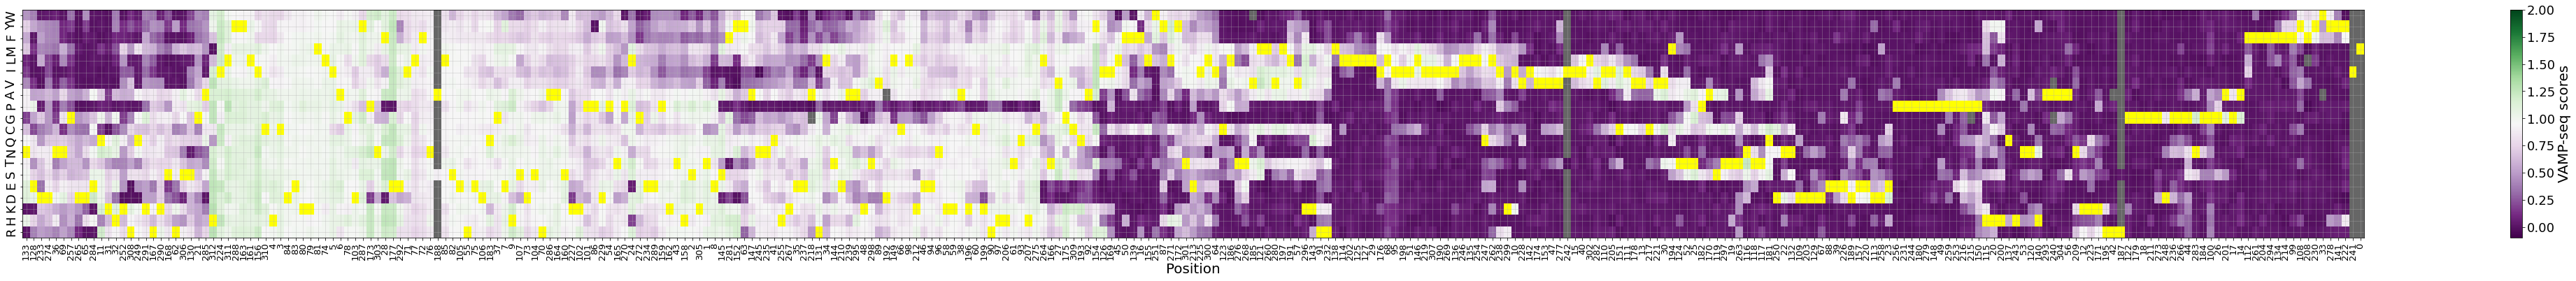

In [128]:
heatmap_scores_reordered_dendogram(ASPA_scores_dn_reorder,'VAMP-seq scores',ASPA_WT_reordered_cluster,2,0,'PRGn',[0,(len(ASPA_WT_sequence)-1-2)],dn['ivl'],figs=[75,6])
#plt.savefig('../Figures/ASPA_heatmap_MAVE_cluster_res_reordered.pdf',dpi=300, facecolor='w')